## 0.0 Imports

In [1]:
%pip install pandas
%pip install scikit-learn
%pip install openpyxl
%pip install --upgrade pip
%pip install matplotlib
%pip install seaborn

import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 1.0 Leitura do conjunto de dados

In [2]:
ds = pd.read_excel('GPS_Data_Simplified_2D_Feature_Map.xlsx',  dtype = str)
ds

,PRN,DO,PD,RX,TOW,CP,EC,LC,PC,PIP,PQP,TCD,CN0,Output
0,6,1160.67140780005,-238359.543281858,491568,491568.000795082,-24660.2632931903,163521.78,170008.81,179294.97,178420.33,-17688.178,1158.4806,49.412529,0
1,6,1157.82780811118,-238363.921192484,491568.02,491568.020795096,-24683.4685202421,158277.05,160253.09,182106.11,182106.05,158.33333,1160.7948,49.452686,0
2,6,1161.13593220979,-238368.638614547,491568.04,491568.040795112,-24706.6873571922,184442.36,193125.89,208228.02,-205198.3,35391.59,1157.6909,49.480145,0
3,6,1161.15661719479,-238373.391774656,491568.06,491568.060795128,-24729.9200394638,159812.45,169960.55,187550.72,187543,-1701.944,1161.1343,49.433769,0
4,6,1160.6908929619,-238378.127065742,491568.08,491568.080795144,-24753.1539994783,183557.66,191912.58,208403.5,208330.05,-5532.8999,1161.1759,49.39167,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510525,4,-1113.336004,1949364.523,264109.58,264109.5735,114898.7034,90875.36719,104455.8516,99626.32031,-95613.48438,27990.45703,-1113.685547,43.05340958,0
510526,7,3542.882288,2823824.599,264109.58,264109.5706,-195707.189,139266.9219,133094.5938,144683.2656,-142087.5469,-27283.24023,3532.388916,46.4665451,0
510527,9,1205.18283,1298452.438,264109.58,264109.5757,-136011.0641,104211.4117,111445.296,125940.9297,-125705.6406,-9212.472557,2779.28833,47.58116531,3
510528,27,2814.03045,2298963.88,264109.58,264109.5723,-300750.7153,107693.0131,121277.7439,133731.1114,132020.7188,-21319.94265,2780.66748,46.21652603,3


### 1.1 Extração das features e da classe


In [3]:
feature_columns = ["PRN","DO","PD",	"RX","TOW","CP","EC","LC","PC",	"PIP","PQP","TCD","CN0"]
X = ds[feature_columns].values
y = ds['Output'].values

ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510530 entries, 0 to 510529
Data columns (total 14 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   PRN     510530 non-null  object
 1   DO      510530 non-null  object
 2   PD      510530 non-null  object
 3   RX      510530 non-null  object
 4   TOW     510530 non-null  object
 5   CP      510530 non-null  object
 6   EC      510530 non-null  object
 7   LC      510530 non-null  object
 8   PC      510530 non-null  object
 9   PIP     510530 non-null  object
 10  PQP     510530 non-null  object
 11  TCD     510530 non-null  object
 12  CN0     510530 non-null  object
 13  Output  510530 non-null  object
dtypes: object(14)
memory usage: 54.5+ MB


### 1.2 Pre-processamento dos dados
Utilização da técnica _Principal Component Analysis (PCA)_

> Esta técnica visa reduzir a dimensão do conjunto de dados.

In [4]:
# código PCA
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_scaled)

### 1.3 Separação dos dados de treinamento e teste
> Separação foi de 70% do conjunto de dados para treino e 30% para testes


In [5]:
# X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



## 2. Treino e teste do K-NN

In [6]:
cl_sklearn = KNeighborsClassifier(n_neighbors=3)
cl_sklearn.fit(X_train, y_train)
y_pred = cl_sklearn.predict(X_test)

### 2.1 Métricas de desempenho do K-NN

In [7]:
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy of KNN Classifier: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision Score: {precision:.4f}")
print(f"Recall Score: {recall:.4f}")
print(f"Error: {1 - accuracy:.4f}")


Accuracy of KNN Classifier: 0.8963
F1 Score: 0.8959
Precision Score: 0.8956
Recall Score: 0.8963
Error: 0.1037


### 2.2 Matriz de confusão

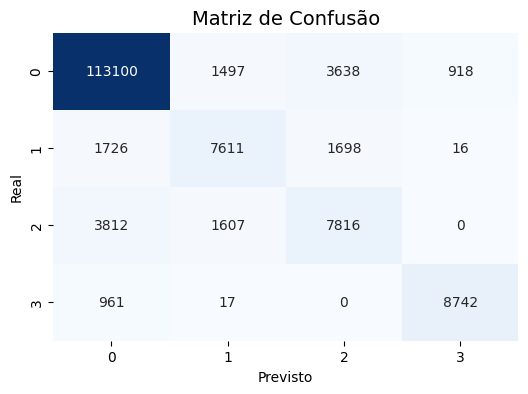

In [8]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

plt.title("Matriz de Confusão", fontsize=14)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

## 3. Treino e teste do Random Forest

In [9]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

### 3.1 Métricas de desempenho do Random Forest

In [10]:
accuracy_rf = accuracy_score(y_test, y_pred)
cm_rf = confusion_matrix(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred, average='weighted')
precision_rf = precision_score(y_test, y_pred, average='weighted')
recall_rf = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy of Random Forest Classifier: {accuracy_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"Precision Score: {precision_rf:.4f}")
print(f"Recall Score: {recall_rf:.4f}")
print(f"Error: {1 - accuracy_rf:.4f}")

Accuracy of Random Forest Classifier: 0.9044
F1 Score: 0.9042
Precision Score: 0.9041
Recall Score: 0.9044
Error: 0.0956


### 3.2 Matriz de confusão

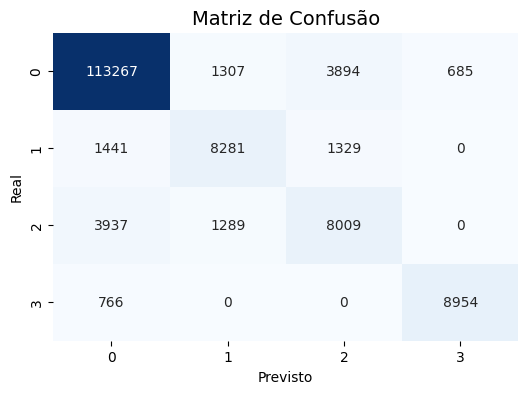

In [11]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", cbar=False)

plt.title("Matriz de Confusão", fontsize=14)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

## 4. Treino e teste do Gausian Naive Bayes

In [12]:
nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

TypeError: GaussianNB.__init__() got an unexpected keyword argument 'n_estimators'

### 4.1 Métricas de desempenho do Gausian Naive Bayes Forest

In [ ]:
accuracy_rf = accuracy_score(y_test, y_pred)
cm_rf = confusion_matrix(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred, average='weighted')
precision_rf = precision_score(y_test, y_pred, average='weighted')
recall_rf = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy of Gausian Naive Bayes: {accuracy_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"Precision Score: {precision_rf:.4f}")
print(f"Recall Score: {recall_rf:.4f}")
print(f"Error: {1 - accuracy_rf:.4f}")

### 4.2 Matriz de confusão

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", cbar=False)

plt.title("Matriz de Confusão", fontsize=14)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()